In [1]:
import scanpy as sc
import anndata as ad
import multigrate
from random import shuffle
from scipy import sparse
from matplotlib import pyplot as plt
import gdown

In [2]:
%config InlineBackend.figure_format = 'retina'

# Load the dataset

In [3]:
gdown.download(
    'https://drive.google.com/uc?id=1W1-YG9CXK1jbqM5vuDT8lHJMgxPyOt-D',
    'kotliarov2020-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1W1-YG9CXK1jbqM5vuDT8lHJMgxPyOt-D
To: /home/aomidi/theis/multigrate/example/kotliarov-expressions.h5ad
420MB [02:22, 2.94MB/s] 


'kotliarov-expressions.h5ad'

In [3]:
scrna = sc.read_h5ad('kotliarov2020-expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 53196 × 3999
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'batch', 'cluster_level1', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'gene_symbols', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cluster_level1_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'hvg', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
gdown.download(
    'https://drive.google.com/uc?id=1hfHJA37_684b63J4-ZMS0Nacw1NxLYCM',
    'kotliarov2020-proteins.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1hfHJA37_684b63J4-ZMS0Nacw1NxLYCM
To: /home/aomidi/theis/multigrate/example/kotliarov-proteins.h5ad
145MB [00:48, 2.96MB/s] 


'kotliarov-proteins.h5ad'

In [4]:
cite = sc.read_h5ad('kotliarov2020-proteins.h5ad')
cite

AnnData object with n_obs × n_vars = 53196 × 87
    obs: 'n_genes', 'batch', 'cluster_level1', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'gene_symbols', 'n_cells'
    uns: 'batch_colors', 'cluster_level1_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Clean the data

In [5]:
# use more general annotation
# can change to cluster_level2 or cluster_level3 if needed (finer annotation)
scrna.obs['cell_type'] = scrna.obs['cluster_level1'].astype(str)
cite.obs['cell_type'] = cite.obs['cluster_level1'].astype(str)

# Paired setting

## Configure and train the model

In [7]:
# paired
model = multigrate.models.MultiVAE(
    adatas=[[scrna], [cite]],
    names=[['scRNA-seq'], ['scCITE-seq']],
    pair_groups=[[0], [0]],
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-3,
    integ_coef=1,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [8]:
model.train(
    n_iters=50000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=20000,
    validate_every=3300,
    verbose=1
)

/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


 |████████████████████| 100.0% iter=50000/50000, time=28.24(s), loss=0.2894, recon=0.1657, kl=83.5627, integ=0.0401, cycle=0.2135, val_loss=0.2557, val_recon=0.1375, val_kl=82.7616, val_integ=0.0354, val_cycle=0.1647

## Plot training history

In [9]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,3300,1.985113,0.280703,54.209095,1.698264,0.342058,1.304951,0.179656,78.275036,1.112379,0.230912
1,6600,0.539333,0.212265,102.359006,0.300975,0.300873,0.540206,0.162237,122.227899,0.337634,0.223648
2,9900,0.284902,0.196450,122.213977,0.039570,0.259010,0.226944,0.145259,115.188511,0.024666,0.179518
3,13200,0.267914,0.174417,107.457751,0.029194,0.214893,0.227192,0.140629,99.513509,0.020884,0.164232
4,16500,0.287096,0.177263,94.848689,0.038753,0.207844,0.245090,0.143365,91.935093,0.025878,0.168201
5,19800,0.299440,0.173952,89.543025,0.044988,0.219136,0.258365,0.140727,85.421817,0.033071,0.166920
6,23100,0.306880,0.172657,84.645851,0.049577,0.209621,0.259676,0.140493,83.857509,0.035326,0.168954
7,26400,0.298240,0.166086,84.480461,0.047674,0.211236,0.255842,0.137042,83.225510,0.035575,0.162386
8,29700,0.295434,0.165799,84.372981,0.045262,0.195354,0.256902,0.137389,82.413307,0.037100,0.165243
9,33000,0.294303,0.164321,82.688657,0.047293,0.208745,0.258903,0.140505,82.105149,0.036293,0.168390


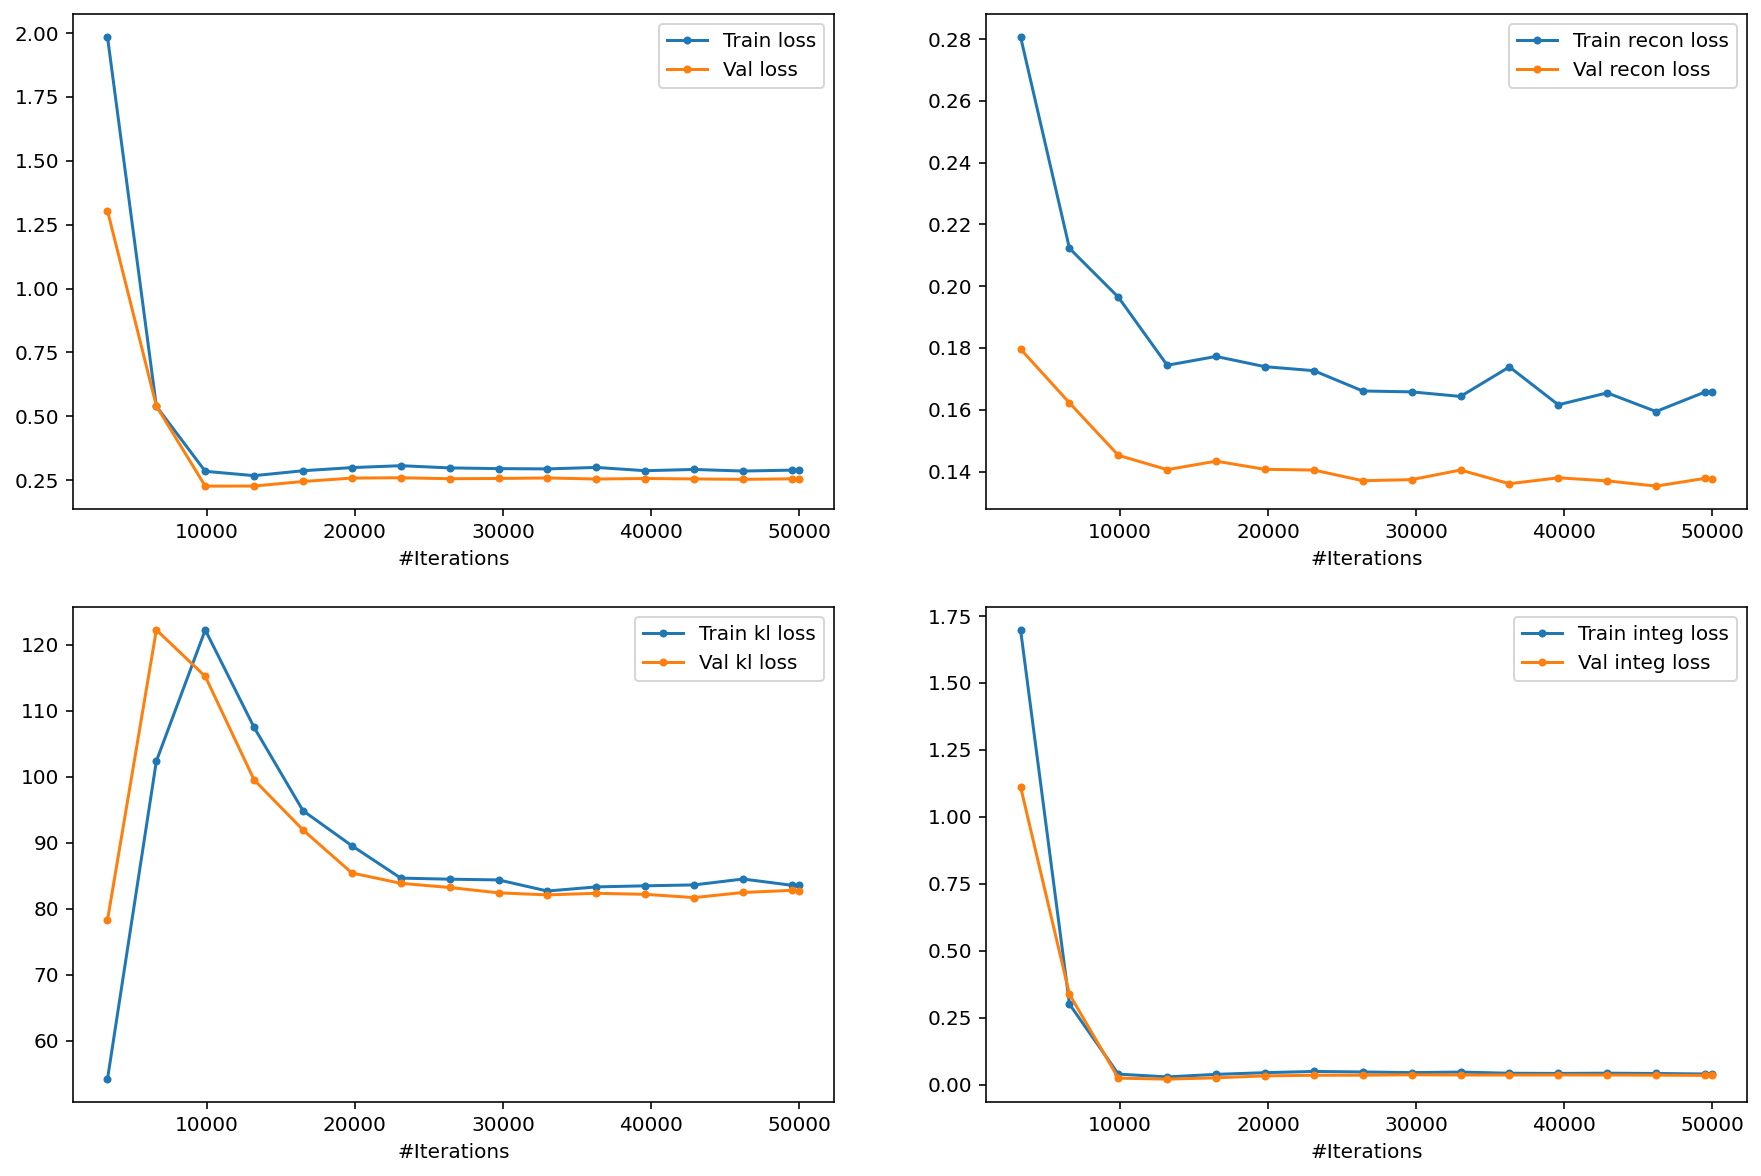

In [10]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Recover and visualize the latent space

In [11]:
z = model.predict(
    adatas=[[scrna], [cite]],
    names=[['scRNA-seq'], ['scCITE-seq']],
    batch_size=64,
)
z

/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 106392 × 20
    obs: 'modality', 'cell_type', 'batch'

In [12]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


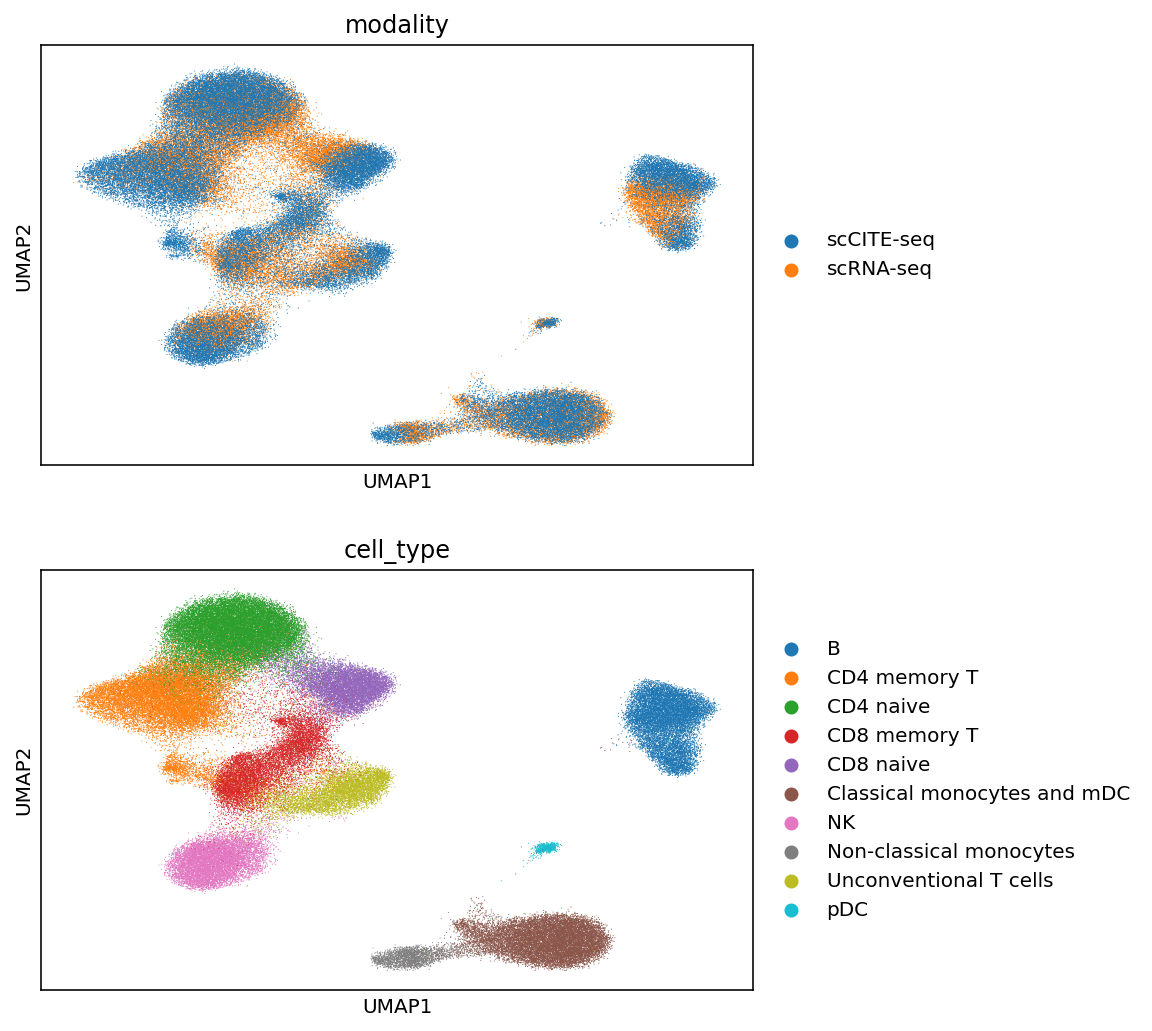

In [13]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

## Metrics

In [14]:
sc.pp.pca(z)
metrics = multigrate.metrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type',
    method='multigrate'
)
metrics

Clustering...
ASW label/batch...


/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_catego

PCR batch...
Graph connectivity...
ASW label...


/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/multigrate-0.1.0-py3.7.egg/multigrate/metrics.py:548: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  _,labs = connected_components(adata_post_sub.uns['neighbors']['connectivities'], connection='strong')


NMI cluster/label...
ARI cluster/label...


/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))


Isolated label silhouette...


KeyboardInterrupt: 